# Hypergraph information

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm
from itertools import combinations
import random

sys.path.append("../src/")

import xgi
from reducibility_hg import *

from statannotations.Annotator import Annotator

sb.set_theme(style="ticks", context="paper")

In [2]:
results_dir = "../results/"
out_dir  = f"{results_dir}synthetic/"

In [19]:
def optimization_rescaled(H, tau, rescaling_factors, rescale_per_node=False, sparse=False):

    orders = np.array(xgi.unique_edge_sizes(H)) - 1
    weights = np.ones(len(orders))
    L_multi = xgi.multiorder_laplacian(
        H, orders, weights, rescale_per_node=rescale_per_node, sparse=sparse
    )

    rho_all = density(L_multi, tau, sparse=sparse)

    D = []  # Learning error
    lZ = []  # Penalization term for model complexity

    for l in range(len(orders)):
        L_l = xgi.multiorder_laplacian(
            H, orders[0 : l + 1], weights[0 : l + 1], rescale_per_node=rescale_per_node, sparse=sparse
        )
        rho_l = density(L_l, tau*rescaling_factors[l], sparse=sparse)
        d = KL(rho_all, rho_l, sparse=sparse)
        z = penalization(L_l, tau*rescaling_factors[l], sparse=sparse)

        D.append(d)
        lZ.append(z)

    lZ = np.array(lZ)
    D = np.array(D)

    return D, lZ

def pad_arr_list(arr_list, max_shape=None):
    
    if max_shape is None:
        max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [
        np.pad(a, (0, max_shape - a.shape[0]), mode="constant", constant_values=None)
        for a in arr_list
    ]
    return padded_arr_list

In [4]:
def plot_3panels(info_losses, complexities, orders, labels, legend_title=None):
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2.1), constrained_layout=True, sharey=True)

    n = len(info_losses)
    
    for i in range(n):
        ax1.plot(orders[i], info_losses[i], "o-", label=labels[i], ms=7, mfc="w", lw=2)      

    ax1.set_title("Information Loss (KL)")
    ax1.set_xlabel("Max Order")
    ax1.set_ylabel("Bits")
    
    for i in range(n):
        ax2.plot(orders[i], complexities[i], "o-", label=labels[i], ms=7, mfc="w", lw=2)      

    ax2.set_title("Model Complexity ($\delta S$)")
    ax2.set_xlabel("Max Order")
    
    for i in range(n):
        message_length = complexities[i] + info_losses[i]
        ax3.plot(orders[i], message_length, "o-", label=labels[i], ms=7, mfc="w", lw=2)

    ax3.legend(title=legend_title, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left")

    ax3.set_title("Message Length")
    ax3.set_xlabel("Max Order")

    sb.despine()

    #fig.suptitle(f"Complete hypergraph N={N}")

    #fig_name = f"message_length_complete_hypergraph_N{N}" #lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

    #plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
    
    return fig, (ax1, ax2, ax3)

In [39]:
rf_1 = 1
rf_2 = rf_1 + 2
rf_3 = rf_2 + 3
rf_4 = rf_3 + 4
rf_5 = rf_4 + 5
inverse_rescaling_factors = np.array([1/rf_1, 1/rf_2, 1/rf_3, 1/rf_4, 1/rf_5]) * rf_5

## Filling hyperedges of order 5

In [48]:
N = 300

n_reps = 10

ps = np.array([10 / N, 25 / N])

Hs = dict()
for p in tqdm(ps):
    Hs_i = []
    for i in range(n_reps):
        H = xgi.random_flag_complex(N, p, max_order=4)
        print(xgi.density(H, order=1))
        Hs_i.append(H)
    Hs[p] = Hs_i

  0%|                                                     | 0/2 [00:00<?, ?it/s]

0.034024526198439244
0.03295429208472687
0.031460423634336675
0.034827201783723526
0.03353400222965441


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.06it/s]

0.03400222965440357
0.03181716833890747
0.03288740245261984
0.033779264214046825
0.033444816053511704
0.08307692307692308
0.08249721293199554
0.08633221850613156
0.08515050167224081
0.08220735785953177
0.08503901895206244
0.08421404682274247
0.08354515050167224
0.0835897435897436


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.14s/it]

0.08231884057971015


In [49]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in tqdm(Hs.items()):
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(H, tau_c, inverse_rescaling_factors, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i      

  0%|                                                     | 0/2 [00:00<?, ?it/s]

logm result may be inaccurate, approximate err = 4.227031517122402e-13
logm result may be inaccurate, approximate err = 2.859967664911037e-13
logm result may be inaccurate, approximate err = 4.227031517122402e-13
logm result may be inaccurate, approximate err = 3.6591988974032797e-13
logm result may be inaccurate, approximate err = 4.4144985521286225e-13
logm result may be inaccurate, approximate err = 4.4144985521286225e-13
logm result may be inaccurate, approximate err = 3.500835482955488e-13
logm result may be inaccurate, approximate err = 4.701664188087381e-13
logm result may be inaccurate, approximate err = 3.2723844376209437e-13
logm result may be inaccurate, approximate err = 4.701664188087381e-13
logm result may be inaccurate, approximate err = 3.6722936898308806e-13
logm result may be inaccurate, approximate err = 4.629621324366191e-13
logm result may be inaccurate, approximate err = 4.86854731374853e-13
logm result may be inaccurate, approximate err = 4.629621324366191e-13
lo

 50%|██████████████████████▌                      | 1/2 [00:36<00:36, 36.19s/it]

logm result may be inaccurate, approximate err = 3.174945920991247e-13
logm result may be inaccurate, approximate err = 4.626425194802188e-13
logm result may be inaccurate, approximate err = 4.754894450857211e-13
logm result may be inaccurate, approximate err = 4.626425194802188e-13
logm result may be inaccurate, approximate err = 4.842898905471031e-13
logm result may be inaccurate, approximate err = 4.626425194802188e-13
logm result may be inaccurate, approximate err = 4.505383272267124e-13
logm result may be inaccurate, approximate err = 4.626425194802188e-13
logm result may be inaccurate, approximate err = 4.482160965430096e-13
logm result may be inaccurate, approximate err = 4.060534740016546e-13
logm result may be inaccurate, approximate err = 3.070406052214227e-13
logm result may be inaccurate, approximate err = 4.060534740016546e-13
logm result may be inaccurate, approximate err = 3.168086747626471e-13
logm result may be inaccurate, approximate err = 4.060534740016546e-13
logm r

100%|█████████████████████████████████████████████| 2/2 [01:35<00:00, 47.82s/it]

logm result may be inaccurate, approximate err = 4.045144110571897e-13


In [50]:
message_lengths

{0.03333333333333333: [array([0.18239266, 0.40010573]),
  array([0.18340088, 0.40366237]),
  array([0.09156717, 0.22621045]),
  array([0.00276235, 0.0029926 , 0.00985147]),
  array([0.09749768, 0.24212453]),
  array([0.14869869, 0.33212981]),
  array([0.1511827 , 0.34349871]),
  array([0.19814024, 0.40997422]),
  array([0.15005388, 0.33515661]),
  array([0.14086113, 0.33421295])],
 0.08333333333333333: [array([0.00614992, 0.00610132, 0.00594485, 0.01206729]),
  array([0.02483018, 0.03823385, 0.08918285]),
  array([0.00635676, 0.00623688, 0.00595344, 0.01229022]),
  array([0.00345271, 0.00350104, 0.0033729 , 0.00641002]),
  array([0.00344716, 0.00345383, 0.0033859 , 0.00635739]),
  array([0.01236261, 0.01928647, 0.04962182]),
  array([0.00427655, 0.00424931, 0.00337424, 0.00796812]),
  array([0.01100474, 0.01701881, 0.04790215]),
  array([0.02330183, 0.03678194, 0.09117029]),
  array([0.01870793, 0.02929953, 0.07788939])]}

In [54]:
for i, s in enumerate(ps):
    print(i, s)
    message_lengths[s] = pad_arr_list(message_lengths[s], max_shape=4)

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["p", "rep"]).melt(
    id_vars=["p", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

0 0.03333333333333333


ValueError: index can't contain negative values

In [55]:
dff

,p,rep,order,message length
0,0.033333,0,1,0.182393
1,0.033333,1,1,0.183401
2,0.033333,2,1,0.091567
3,0.033333,3,1,0.002762
4,0.033333,4,1,0.097498
5,0.033333,5,1,0.148699
6,0.033333,6,1,0.151183
7,0.033333,7,1,0.198140
8,0.033333,8,1,0.150054
9,0.033333,9,1,0.140861


ValueError: Missing hue value `4` in order (specified in `pairs`)

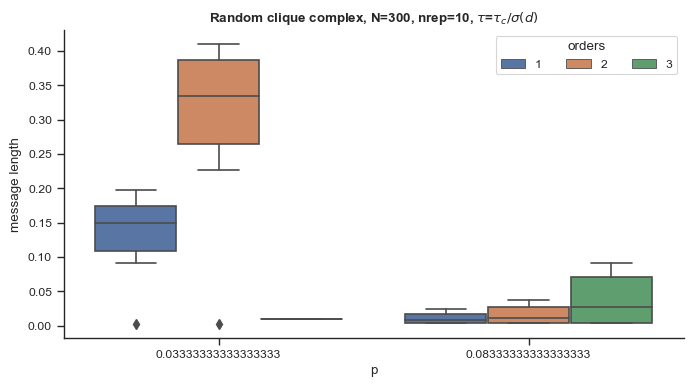

In [56]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(data=dff, hue="order", y="message length", x="p", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

#sb.stripplot(data=dff, hue="order", y="message length", x="p", ax=ax, color="black", dodge=True, alpha=0.1)#, legend=False)

sb.despine()
ax.set_title(rf"Random clique complex, N={N}, nrep={n_reps}, $\tau$=$\tau_c/\sigma(d)$", weight="bold")


pairs = []
for p in ps:
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )
    pairs.append( [(p, 1), (p, 5) ] )
    pairs.append( [(p, 5), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="p", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RFG_N_{N}_ps_{ps}_tau_1_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")